# Классификация изображений: Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

Обучить модель классификации изображение на 2 класса. 
Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. 
Шаблон ipython-ноутбука для решения можно скачать по ссылке. 
Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. 
Задание засчитывается при значениях метрики Log Loss меньше 0.3.

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.6.2
True


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

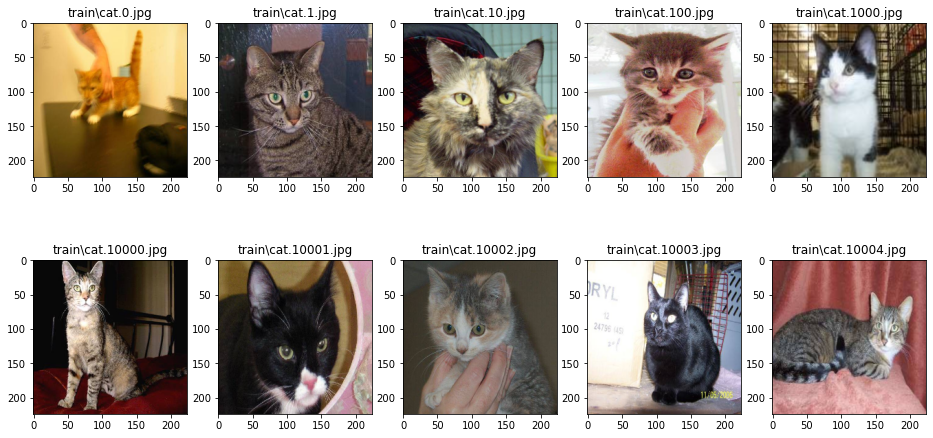

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# фиксируем все веса предобученной сети
for layer in model.layers:
    layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)

model = Model(inputs=model.inputs, outputs=output, name='dogs_vs_cats')

## Выводим архитектуру модели

In [7]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [8]:
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
steps_num = 10
epochs_num = 50
val_samples = 250  # число изображений в валидационной выборке

In [10]:
shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch = steps_num, # число вызовов генератора за эпоху
          epochs = epochs_num, # число эпох обучения
          validation_data=validation_data)

Epoch 1/50
10/10 [==============================] - 147s 15s/step - loss: 3.2302 - accuracy: 0.8625 - val_loss: 1.0552 - val_accuracy: 0.9560
Epoch 2/50
10/10 [==============================] - 140s 15s/step - loss: 0.5329 - accuracy: 0.9781 - val_loss: 0.7315 - val_accuracy: 0.9680
Epoch 3/50
10/10 [==============================] - 144s 15s/step - loss: 0.6855 - accuracy: 0.9688 - val_loss: 0.5856 - val_accuracy: 0.9640
Epoch 4/50
10/10 [==============================] - 143s 15s/step - loss: 0.8012 - accuracy: 0.9469 - val_loss: 0.4939 - val_accuracy: 0.9440
Epoch 5/50
10/10 [==============================] - 144s 15s/step - loss: 0.1877 - accuracy: 0.9750 - val_loss: 0.2534 - val_accuracy: 0.9560
Epoch 6/50
10/10 [==============================] - 142s 15s/step - loss: 0.1848 - accuracy: 0.9656 - val_loss: 0.1967 - val_accuracy: 0.9640
Epoch 7/50
10/10 [==============================] - 141s 15s/step - loss: 0.1460 - accuracy: 0.9719 - val_loss: 0.1616 - val_accuracy: 0.9760
Epoch 

In [11]:
model.save(f'cats-dogs-vgg16_{steps_num}_{epochs_num}.hdf5')

## Предсказания на проверочной выборке

In [12]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

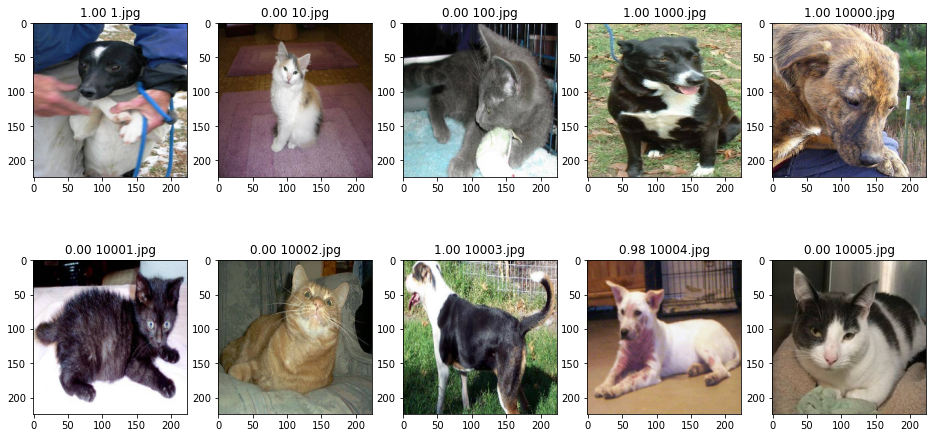

In [13]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [14]:
import re

with open(f'submit_{steps_num}_{epochs_num}.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

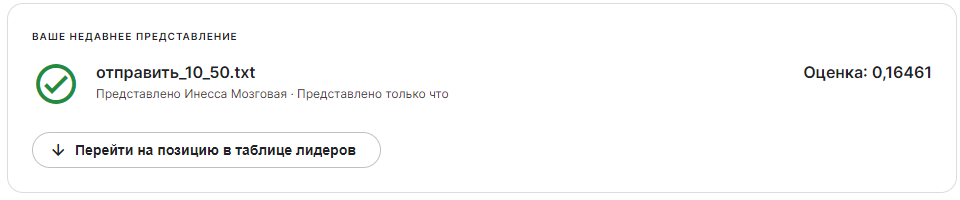
